## Importing libraries

In [1]:
# Input and Output from Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stage 1 - Deep Learning

## Get the data

In [2]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-1, 1, num_samples) # Input random
    # x = np.random.randint(-100, 100, num_samples) # Input random
    t = np.zeros(num_samples)
    
    t[0] = 0   # Inisialisasi
    
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]
    
    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)

              x         t
0     -0.845632  0.000000
1      0.983900  1.499664
2      0.776994  0.206866
3      0.690187  0.898411
4     -0.708780  0.169109
...         ...       ...
29997 -0.795436  0.779297
29998  0.149109  0.898068
29999 -0.845289  0.297494
30000  0.375874  1.266249
30001  0.606315  0.422932

[30002 rows x 2 columns]


In [3]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)    t(t-1)    t(t-2)      t(t)
0  0.776994  0.983900 -0.845632  1.499664  0.000000  0.206866
1  0.690187  0.776994  0.983900  0.206866  1.499664  0.898411
2 -0.708780  0.690187  0.776994  0.898411  0.206866  0.169109
3  0.668205 -0.708780  0.690187  0.169109  0.898411  1.351883
4 -0.969710  0.668205 -0.708780  1.351883  0.169109 -0.089230
(30000, 6)


In [4]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)", "t(t-1)", "t(t-2)"]].values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

(30000, 5) (30000, 1)


## Splitting the dataset

In [5]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    assert len(X) == len(T), "Jumlah X dan T harus sama"
    assert len(X) == 30000, "Dataset harus 30.000 sample sesuai aturan"

    # Train 15.000 pertama
    X_train = X[:15000]
    T_train = T[:15000]

    # Validation = 5000 terakhir train + 5000 setelah train
    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    # Test = 10000 terakhir
    X_test = X[20000:30000]
    T_test = T[20000:30000]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 5) (15000, 1)
Val  : (10000, 5) (10000, 1)
Test : (10000, 5) (10000, 1)


## Neural Network Model

In [6]:
from MyKeras.models import NN, NARX_NN
from MyKeras.layers import Dense
from MyKeras.callbacks import EarlyStopping

# create MLP model
model = NN()
model.add(Dense(units=10, activation='sigmoid', input_shape=X_train.shape[1]))
model.add(Dense(units=20, activation='sigmoid'))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', lr=0.01)

## Training and Validation

In [7]:
# training
# early_stopping_criteria = EarlyStopping(patience=100, restore_best_weights=True)
# history = model.fit(X_train, T_train, X_val, T_val, epochs=10000, tol=1e-3, callbacks=[early_stopping_criteria])
history = model.fit(X_train, T_train, X_val, T_val, epochs=1000)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

# saving weights from previous training
weights = model.get_best_weights()

Epoch 1: train_loss=0.124020, val_loss=0.109392
Epoch 10: train_loss=0.000540, val_loss=0.000508
Epoch 20: train_loss=0.000492, val_loss=0.000457
Epoch 30: train_loss=0.000472, val_loss=0.000437
Epoch 40: train_loss=0.000448, val_loss=0.000415
Epoch 50: train_loss=0.000419, val_loss=0.000388
Epoch 60: train_loss=0.000383, val_loss=0.000354
Epoch 70: train_loss=0.000333, val_loss=0.000308
Epoch 80: train_loss=0.000273, val_loss=0.000252
Epoch 90: train_loss=0.000213, val_loss=0.000197
Epoch 100: train_loss=0.000165, val_loss=0.000154
Epoch 110: train_loss=0.000131, val_loss=0.000122
Epoch 120: train_loss=0.000105, val_loss=0.000098
Epoch 130: train_loss=0.000085, val_loss=0.000079
Epoch 140: train_loss=0.000071, val_loss=0.000067
Epoch 150: train_loss=0.000062, val_loss=0.000058
Epoch 160: train_loss=0.000055, val_loss=0.000052
Epoch 170: train_loss=0.000051, val_loss=0.000048
Epoch 180: train_loss=0.000047, val_loss=0.000045
Epoch 190: train_loss=0.000045, val_loss=0.000043
Epoch 200: 

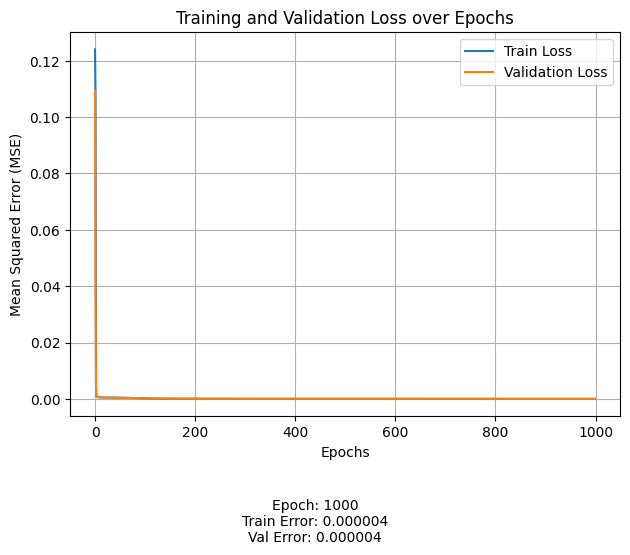

In [8]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

# Stage 2

## Getting the Data

In [9]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)      t(t)
0  0.776994  0.983900 -0.845632  0.206866
1  0.690187  0.776994  0.983900  0.898411
2 -0.708780  0.690187  0.776994  0.169109
3  0.668205 -0.708780  0.690187  1.351883
4 -0.969710  0.668205 -0.708780 -0.089230
(30000, 4)


## Splitting the dataset

In [10]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values   # 100 sampel, input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)


## Training and validation

In [11]:
# NARX model should be the same as MLP model defined earlier
y_lags = 2
model2 = NARX_NN()
model2.add(Dense(units=10, activation='sigmoid', input_shape=X_train.shape[1]+y_lags))
model2.add(Dense(units=20, activation='sigmoid'))
model2.add(Dense(units=1))
model2.compile(loss='mean_squared_error', lr=0.01)
model2.set_weights(weights)
history = model2.fit(X_train, T_train, X_val, T_val, y_lags=y_lags, epochs=1000, tol=1e-6)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

Epoch 1: train_loss=0.098460, val_loss=0.007764
Epoch 10: train_loss=0.000217, val_loss=0.000186
Epoch 20: train_loss=0.000130, val_loss=0.000109
Epoch 30: train_loss=0.000096, val_loss=0.000079
Epoch 40: train_loss=0.000079, val_loss=0.000064
Epoch 50: train_loss=0.000070, val_loss=0.000056
Epoch 60: train_loss=0.000064, val_loss=0.000050
Epoch 70: train_loss=0.000059, val_loss=0.000047
Epoch 80: train_loss=0.000056, val_loss=0.000044
Epoch 90: train_loss=0.000053, val_loss=0.000041
Epoch 100: train_loss=0.000051, val_loss=0.000039
Epoch 110: train_loss=0.000050, val_loss=0.000038
Epoch 120: train_loss=0.000048, val_loss=0.000036
Epoch 130: train_loss=0.000047, val_loss=0.000035
Epoch 140: train_loss=0.000046, val_loss=0.000034
Epoch 150: train_loss=0.000045, val_loss=0.000033
Epoch 160: train_loss=0.000044, val_loss=0.000033
Epoch 170: train_loss=0.000043, val_loss=0.000032
Epoch 180: train_loss=0.000042, val_loss=0.000031
Epoch 190: train_loss=0.000042, val_loss=0.000031
Epoch 200: 

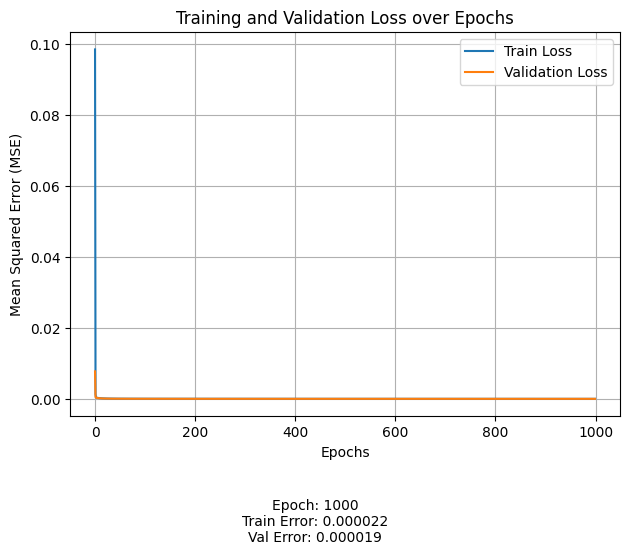

In [12]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [14]:
from MyKeras.losses import mse

# testing
predictions = model2.predict(X_test)
mse_test = mse(predictions, T_test)

print("Predictions:", predictions.flatten())
print("Test MSE:", mse_test)

Predictions: [0.51596294 1.347737   0.82260492 ... 0.45722458 1.38516691 0.75299835]
Test MSE: 0.2546890708786821


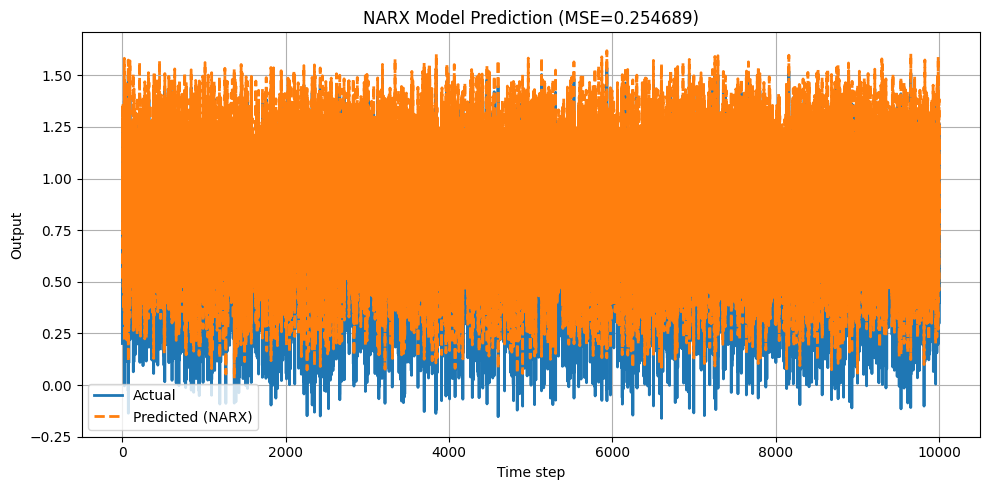

In [16]:
# --- prediction vs target plot ---
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(predictions.flatten(), label='Predicted (NARX)', linestyle='--', linewidth=2)
plt.title(f'NARX Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()